In [73]:
import numpy as np
import xarray as xr
import dask
import gcsfs
import intake
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import nc_time_axis

mpl.rcParams['figure.figsize'] = 12, 8
mpl.rcParams['font.size'] = 16

In [74]:
url = "https://raw.githubusercontent.com/andrewpauling/cmip6hack-so-project/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,pr,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,prsn,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tas,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmin,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN


In [75]:
cat = col.search(experiment_id='historical', member_id='r1i1p1f1', table_id='SImon', variable_id='siconc',
                grid_label='gn')
cat.df.head()
cat_dict = cat.unique()

# Get the models that have both sea ice concentration and grid cell area

In [76]:
cat2 = col.search(variable_id='areacello', experiment_id='historical', grid_label='gn')
cat2_dict = cat2.unique()

model1 = cat_dict['source_id']['values']
model2 = cat2_dict['source_id']['values']

# Use intersection to find the entries that are in both lists
modelsboth = set(model1).intersection(model2)
modelsboth

cat_filtered = cat.search(source_id=list(modelsboth))
cat2_filtered = cat2.search(source_id=list(modelsboth))

# Load dataets into dataset dictionaries

In [77]:
ds_dict = cat_filtered.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False},
                                       cdf_kwargs={'chunks': {}, 'decode_times': True})
ds_dict2 = cat2_filtered.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False},
                                         cdf_kwargs={'chunks': {}, 'decode_times': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 6 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 6 group(s)


# Do Plotting

CMIP.CCCma.CanESM5.historical.SImon.gn
1980
CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.SImon.gn
1980
CMIP.IPSL.IPSL-CM6A-LR.historical.SImon.gn
1980
CMIP.MIROC.MIROC6.historical.SImon.gn
1980
CMIP.NCAR.CESM2.historical.SImon.gn
1980
CMIP.SNU.SAM0-UNICON.historical.SImon.gn
1980


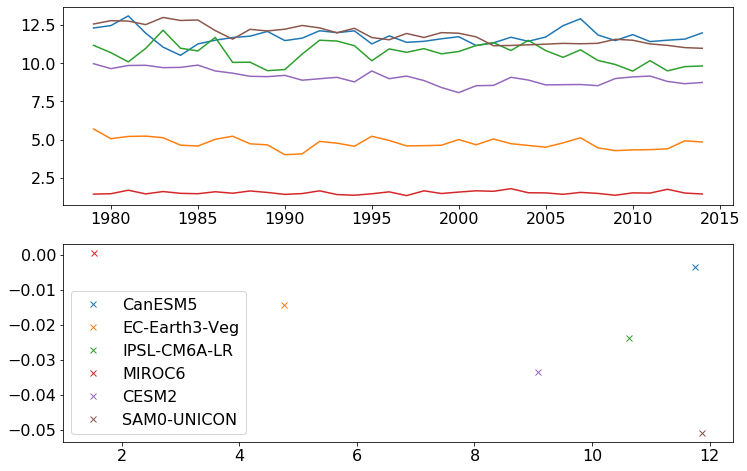

In [88]:
# Keys for the sea ice area and cell area dataset dictionaries
sikeys = list(ds_dict.keys())
okeys = list(ds_dict2.keys())

modlist = list()

# Define time vectors
time = np.linspace(1980, 2006, 312)
tANN = np.arange(1979, 2015)

fig, (ax1, ax2) = plt.subplots(2, 1)

# Loop over the models and compute sea ice area time-series and plot
for n in np.arange(len(sikeys)):
    print(sikeys[n])
    ds = ds_dict[sikeys[n]].squeeze()
    print(ds.time.shape[0])
    ds2 = ds_dict2[okeys[n]].squeeze()
    siconc = ds['siconc']
    siconc = ds['siconc'][-432:, :int(ds[siconc.dims[2]].shape[0]/2), :]
    
    if 'member_id' not in ds2.dims:
        areacell = ds2['areacello'][:int(ds[siconc.dims[2]].shape[0]/2), :]
    else:
        areacell = ds2['areacello'][0, :int(ds[siconc.dims[2]].shape[0]/2), :].squeeze()
    
    siarea = siconc*areacell.data/1e14
    siarea_tseries = np.sum(siarea, axis=(1, 2))
    siarea_ANN = np.mean(np.reshape(np.array(siarea_tseries.data), (12, 36), order='F'), axis=0)
    
    ax1.plot(tANN, siarea_ANN)
    
    modlist.append(sikeys[n].split('.')[2])
    
    trend = get_trend(siarea_ANN)
    
    simag = np.mean(siarea_ANN)
    
    ax2.plot(simag, trend, 'x')
    
plt.legend(modlist)
    
    

In [86]:
def get_trend(siarea):
    time = np.arange(1979, 2015)
    
    p = np.polyfit(time, siarea, 1)
    trend = p[0]
    
    return trend
    
p = get_trend(siarea_ANN)
p

-0.0508078425393901